# 資料增補 (Data Augmentation)

In [55]:
# 載入套件
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os

## 1. 從網路取得壓縮檔，並解壓縮
## 2. 將資料檔名整理為data frame 

In [56]:
DATA_PATH = "../dogs-vs-cats"
filenames = os.listdir(DATA_PATH+"/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


## 資料探索(EDA)

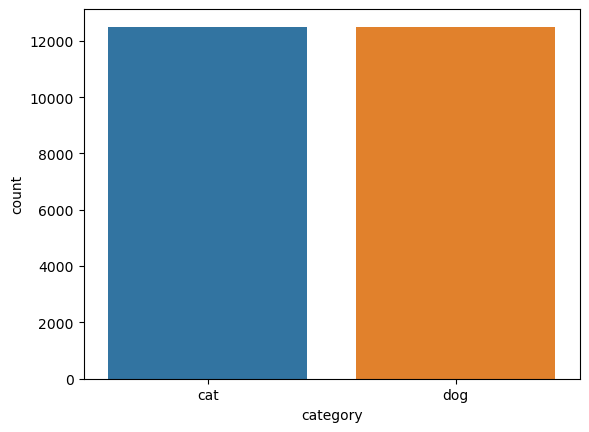

In [57]:
import seaborn as sns

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
chart = sns.countplot(data=df, x='category', hue='category')

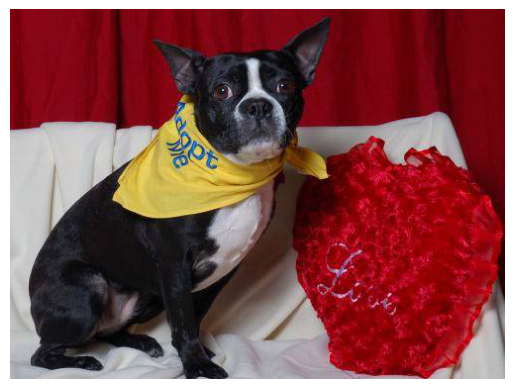

In [58]:
sample = random.choice(filenames)
image = load_img(DATA_PATH+"/train/"+sample)
plt.axis('off')
plt.imshow(image);

## 參數定義

In [59]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## 資料分割

In [60]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

## 以data frame為基礎，建立訓練(Training)及驗證(Validation)資料集

## Training Generator

In [61]:
#定義資料增補(Data Augmentation)
batch_size=64
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_PATH+"/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation Generator

In [62]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DATA_PATH+"/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## 測試generator：隨機顯示訓練資料15筆資料增補的影像

Found 1 validated image filenames belonging to 1 classes.


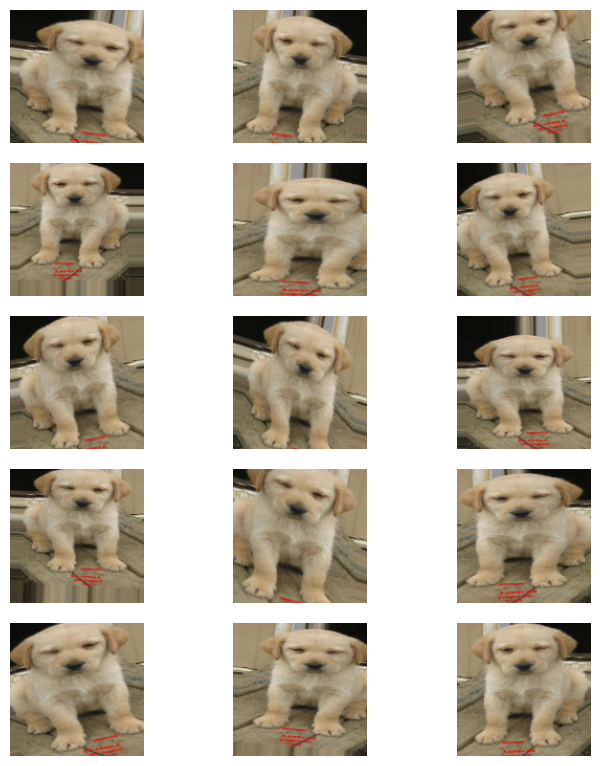

In [63]:
# 隨機挑選一筆資料
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    DATA_PATH+"/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

# 顯示訓練資料前9筆影像
plt.figure(figsize=(8, 8))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
    plt.tight_layout()
    plt.axis("off")

## 定義模型及訓練

In [64]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()
model.add(Input((IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [65]:
# 有點久
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
)

C:\Users\mikec\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.6043 - loss: 1.0040 - val_accuracy: 0.5072 - val_loss: 1.1548
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 295s 942ms/step - accuracy: 0.7269 - loss: 0.5488 - val_accuracy: 0.5900 - val_loss: 1.3288
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 289s 922ms/step - accuracy: 0.7733 - loss: 0.4731 - val_accuracy: 0.7536 - val_loss: 0.5275


## 模型存檔

In [66]:
model.save("pet_model.keras")

## 顯示訓練結果

In [68]:
history.history

{'accuracy': [0.6435499787330627, 0.7426499724388123, 0.7785500288009644],
 'loss': [0.7774858474731445, 0.5239424109458923, 0.46328404545783997],
 'val_accuracy': [0.5072000026702881, 0.5899999737739563, 0.753600001335144],
 'val_loss': [1.154786229133606, 1.328753113746643, 0.5274890065193176]}

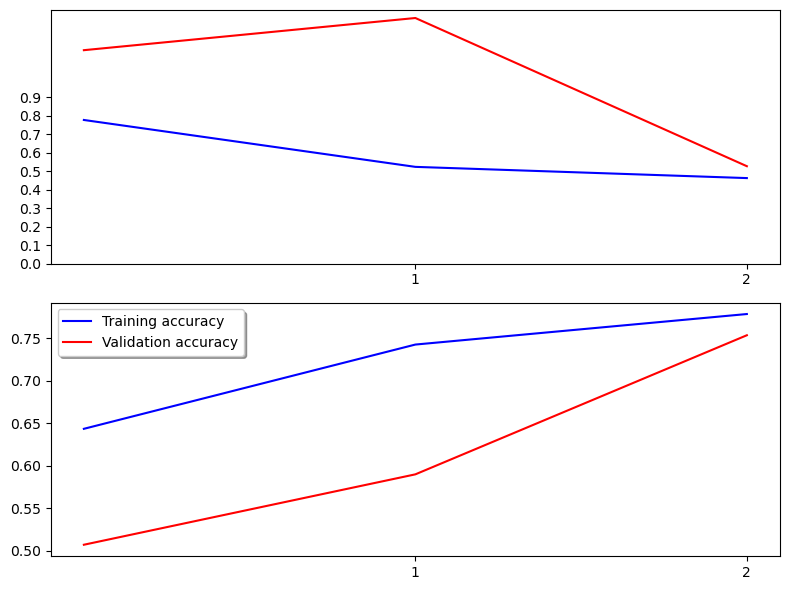

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## 模型評分

In [70]:
test_filenames = os.listdir(DATA_PATH+"/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
test_df.head()

In [75]:
test_df.head()

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


## 模型預測

In [95]:
test_data = None
for i, filename in enumerate(os.listdir(DATA_PATH+"/test1")):
    if i>=20: break
    image = load_img(DATA_PATH+"/test1/"+filename, target_size=IMAGE_SIZE)
    if test_data is None:
        test_data = tf.expand_dims(tf.convert_to_tensor(image), 0)
    else:
        test_data = tf.concat([test_data, tf.expand_dims(tf.convert_to_tensor(image), 0)], axis=0)
print(test_data.shape)


(20, 128, 128, 3)


In [96]:
test_df = test_df.iloc[:20].copy()
predict = model.predict(test_data)
test_df['category'] = np.argmax(predict, axis=-1)
test_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


,filename,category
0,1.jpg,1
1,10.jpg,0
2,100.jpg,0
3,1000.jpg,0
4,10000.jpg,0


In [99]:
test_df['category'] = test_df['category'].map({ 1:'dog', 0:'cat' })
test_df.head()

,filename,category
0,1.jpg,dog
1,10.jpg,cat
2,100.jpg,cat
3,1000.jpg,cat
4,10000.jpg,cat


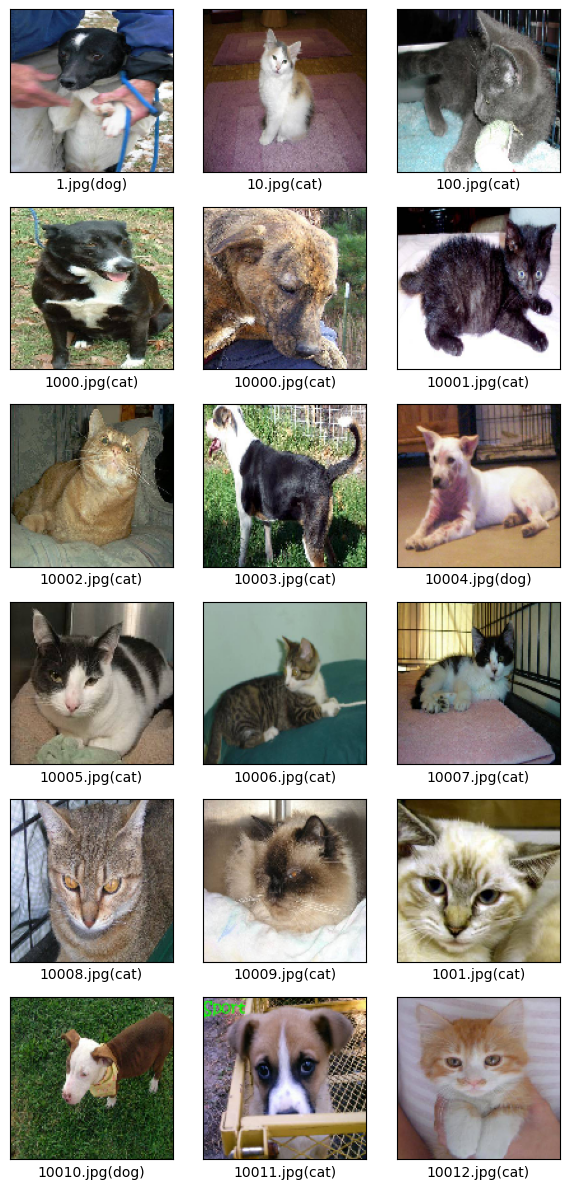

In [107]:
sample_test = test_df.head(18)
plt.figure(figsize=(6, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(DATA_PATH+"/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )

plt.tight_layout()
plt.show()